<h1> Stéganographie par LSB </h1>
<i>par Claudia Delgado et Mehdi Miah - Mars 2017</i>

# Plan 

1. [Import](#import)
2. [Preambule](#preambule)
3. [Choices of images](#choices_images)
4. [Cleaning the images](#cleaning)
5. [Functions to code and decode](#functions)
6. [Application](#application)
    1. [Encoding](#encoding)
    2. [Decoding knowing the hyperparameter](#decoding)
    3. [When the parameter is unknown : 7 different outputs](#7outputs)
    4. [Better choice of the hyperparameter `nb_hidden_bits_decode` through nuclear norm minimisation](#nuclear)
    5. [Finding the optimal parameter by resolving an equation](#equation)

# Import <a name="import"></a>

In [3]:
from scipy import misc
import numpy as np
from PIL import Image
import time
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt

%matplotlib inline

# Preambule <a name="preambule"></a>

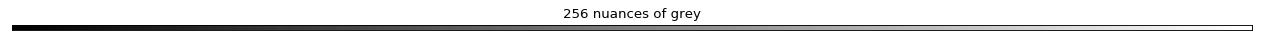

In [4]:
plt.figure(figsize = (20,20), dpi = 80)

plt.imshow(np.linspace(0, 255, 256).reshape((1,256)) , cmap=plt.cm.gray)
plt.title('256 nuances of grey')
plt.xticks([])
plt.yticks([])

plt.show()

Moving to the right means that the number is incremented by one.
The `0` is on the far left and the `255` on the far right.

# Choices of images <a name="choices_images"></a>

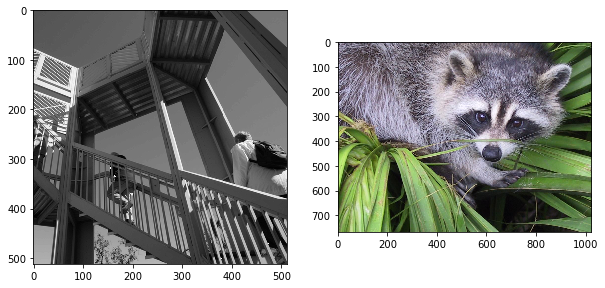

In [5]:
#Choices of the carrier and the hidden
original_carrier = misc.ascent()
original_hidden = misc.face()

#Plot
plt.figure(figsize = (10,10))
plt.subplot(1, 2, 1)
plt.imshow(original_carrier, cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
plt.imshow(original_hidden)

# Cleaning the images <a name="cleaning"></a>

Both images do not have the same size :

In [3]:
# Shapes of images
print('The carrier image is', original_carrier.shape)
print('The hidden image is', original_hidden.shape)

The carrier image is (512, 512)
The hidden image is (768, 1024, 3)


In [6]:
# Test if the two inputs have the same size
if original_carrier.shape == original_hidden.shape:
    print('OK, the two inputs have the same dimensions.')
else:
    print('BEWARE, you have to trunc an image.')
    
# Optimal size    
x_min = min(original_carrier.shape[0], original_hidden.shape[0])
y_min = min(original_carrier.shape[1], original_hidden.shape[1])

print('The best dimension size is %.f x %.f.' %(x_min , y_min))

BEWARE, you have to trunc an image.
The best dimension size is 512 x 512.


In [7]:
#Correction of the hidden image
hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
hidden = hidden[:,:,0]
carrier = original_carrier

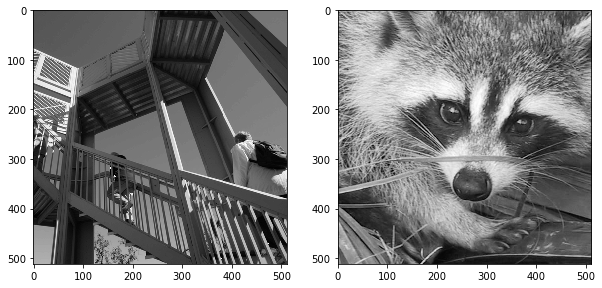

In [8]:
#Cleaned images (same dimensions)
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier, cmap=plt.cm.gray)#, interpolation="none")
plt.subplot(1,2,2)
plt.imshow(hidden, cmap=plt.cm.gray)#, interpolation="none")

In [9]:
#Sanity check
print(carrier.shape == hidden.shape)

True


# Functions to code and decode <a name="functions"></a>

In [10]:
def code_steganography_lsb(carrier, hidden, nb_hidden_bit=1):
    '''
    Input : carrier - number between 0 and 255 corresponding to the bit code of the carrier image
          : hidden - number between 0 and 255 corresponding to the bit code of the hidden image
          : nb_hidden_bit - the number of hidden bits
    Output : output - image resulting from the code      
    '''
    #check that the number is an integer between 1 and 7 included
    assert nb_hidden_bit in range(1,8), "nb_hidden_bit should be between 1 and 7"

    #Binary of the carrier
    bin_carrier = format(carrier,'08b')

    #Binary of the hidden
    bin_hidden = format(hidden,'08b')

    #Result of the LSB algorithm
    bin_output = bin_carrier[:-nb_hidden_bit] + bin_hidden[:nb_hidden_bit-8]
    output = int(bin_output, 2)

    return output

In [11]:
def decode_steganography_lsb(output, nb_hidden_bit=1):
    '''
    Input : output - number between 0 and 255 corresponding to the bit code of the output image
          : nb_hidden_bit - the number of hidden bits
    '''
    #check that the number is an integer between 1 and 7 included
    assert nb_hidden_bit in range(1,8), "nb_hidden_bit should be between 1 and 7"

    #Binary of the output
    bin_output = format(output,'08b')

    #Decode the binary code
    #for the carrier
    bin_carrier = bin_output[:8-nb_hidden_bit] + '0'*nb_hidden_bit
    carrier = int(bin_carrier , 2)

    #for the hidden
    bin_hidden = bin_output[-nb_hidden_bit:] + '0'*(8-nb_hidden_bit)
    hidden = int(bin_hidden , 2)

    return carrier, hidden

In [13]:
def lsb_to_msb(image, nb_bits = 1):
    '''
    Put the lsb of image to the msb of the output
    '''
    #binary code
    bin_image = format(image,'08b')
    
    #put the lsb to the msb and add some '0'
    bin_output = bin_image[-nb_bits:] + '0'*(8-nb_bits) 
    
    #decimal output
    output = int(bin_output, 2)
        
    return(output)

# Application <a name="application"></a>

## Encoding <a name="encoding"></a>

In [25]:
%%time
#Encode
nb_hidden_bits_encode = 3

#Encode for each pixel
output = carrier.copy()
for i in range(carrier.shape[0]):
    for j in range(carrier.shape[1]):
        output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)

Wall time: 1.36 s


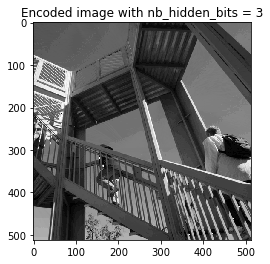

In [26]:
# Plot the result of the encoding
plt.imshow(output, cmap=plt.cm.gray)
plt.title('Encoded image with nb_hidden_bits = %.0f' %nb_hidden_bits_encode)

The change is barely visible, which is great !

## Decoding knowing the hyperparameter <a name="decoding"></a>

In [16]:
%%time
#Decode
nb_hidden_bits_decode = nb_hidden_bits_encode #the best hyperparameter

#Decode for each pixel
carrier_decode = output.copy()
hidden_decode = output.copy()
for i in range(output.shape[0]):
    for j in range(output.shape[1]):
        carrier_decode[i,j], hidden_decode[i,j] = decode_steganography_lsb(output[i,j], nb_hidden_bits_decode)

Wall time: 1.29 s


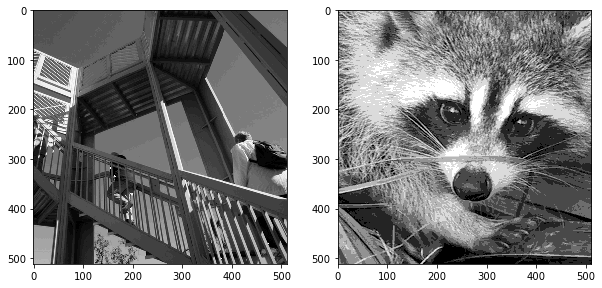

In [17]:
#Decoded images 
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.imshow(carrier_decode, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(hidden_decode, cmap=plt.cm.gray)

Here, one knew that the optimal hyperparameter `nb_hidden_bits_decode`.
What happens if one does not know it ?

## When the parameter is unknown : 7 different outputs  <a name="7outputs"></a>

In [19]:
%%time

all_carrier_decode = []
all_hidden_decode = []

#Decode with different values of nb_hidden_bits_decode
for nb_hidden_bits_decode in range(1,8):
    carrier_decode = output.copy()
    hidden_decode = output.copy()

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            carrier_decode[i,j], hidden_decode[i,j] = decode_steganography_lsb(output[i,j], nb_hidden_bits_decode)
    all_carrier_decode.append(carrier_decode)
    all_hidden_decode.append(hidden_decode)

Wall time: 9.14 s


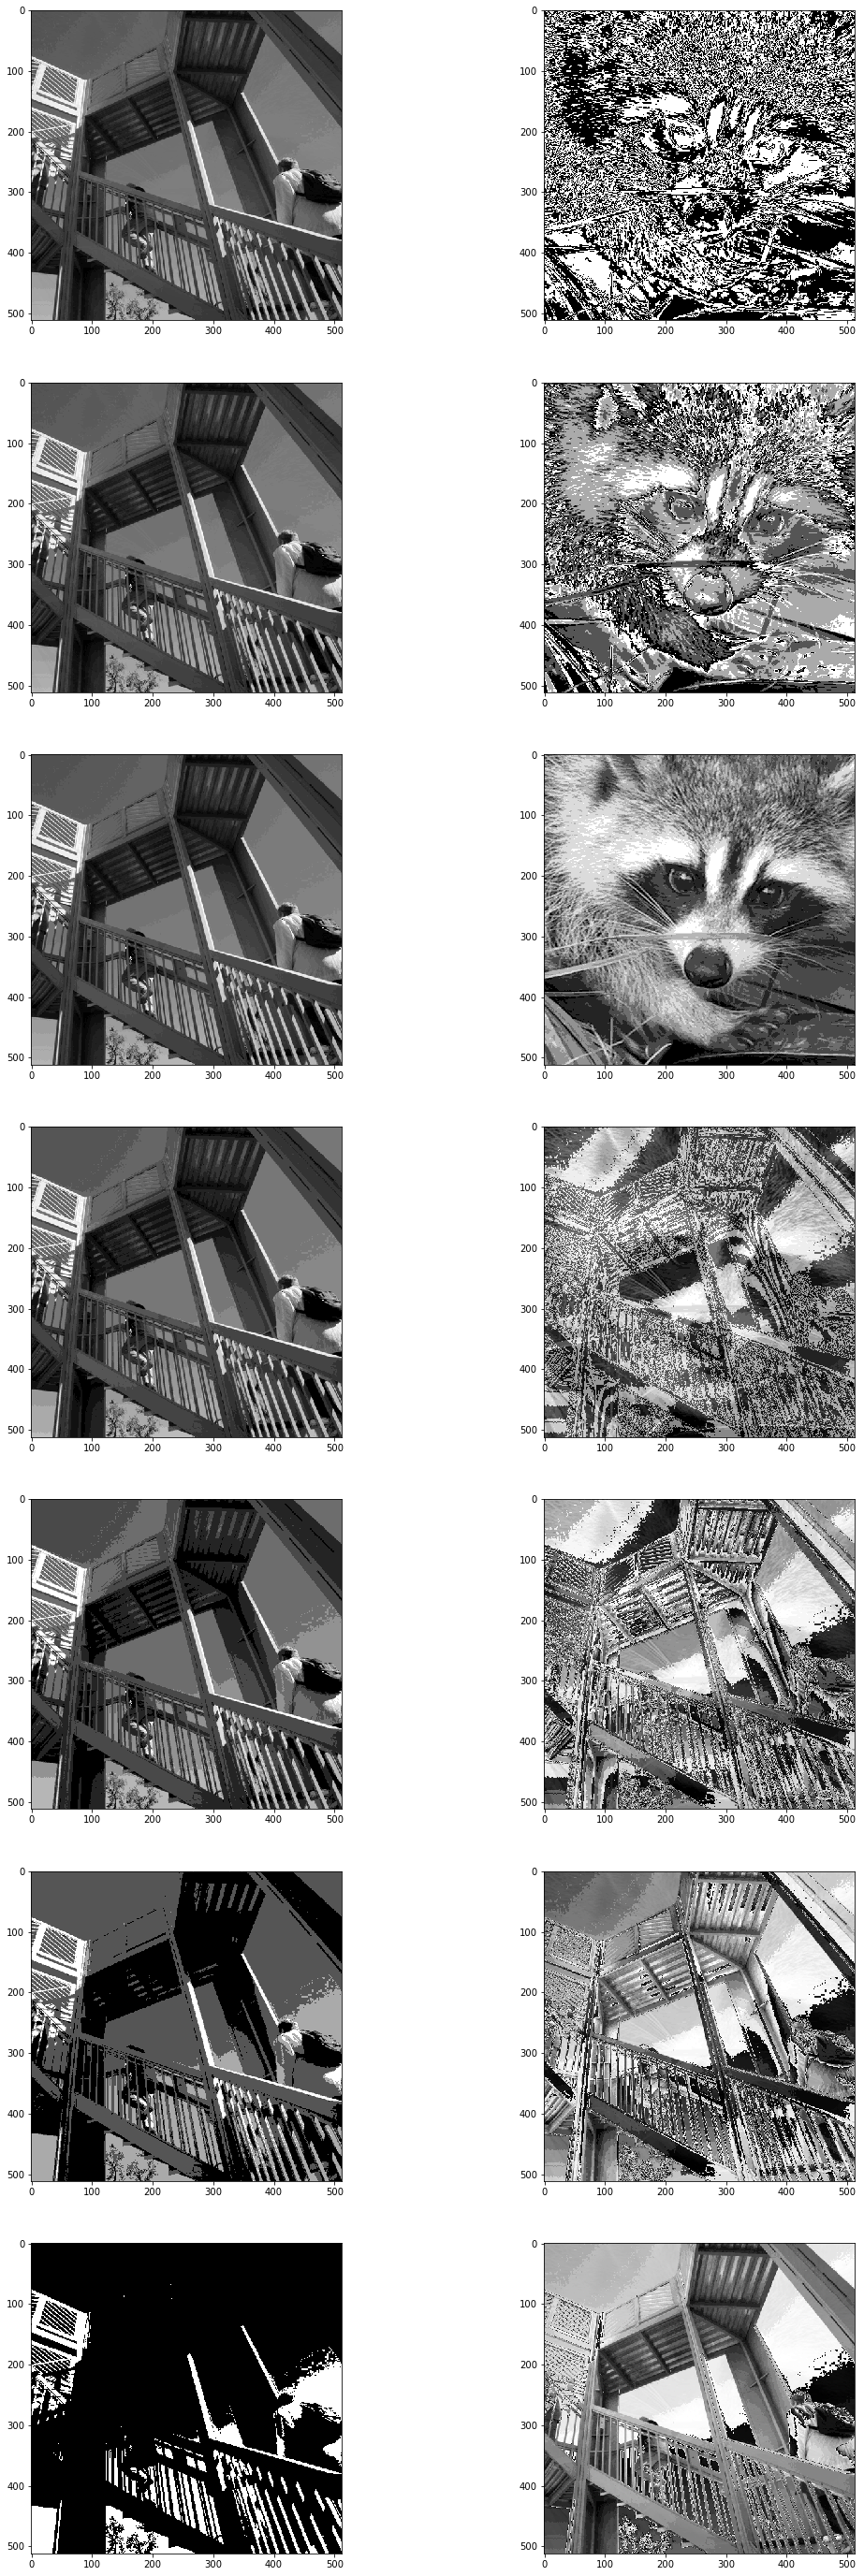

In [20]:
#Plot all Decoded images 
plt.figure(figsize = (18,50))

for nb_hidden_bits_decode in range(0,7):
    plt.subplot(7,2,nb_hidden_bits_decode*2+1)
    plt.imshow(all_carrier_decode[nb_hidden_bits_decode], cmap=plt.cm.gray)
    plt.subplot(7,2,nb_hidden_bits_decode*2+2)
    plt.imshow(all_hidden_decode[nb_hidden_bits_decode], cmap=plt.cm.gray)

One can notice that if the paramater is not correct, the hidden image has a lot noise. This noise increases the nuclear norm of this image. Indeed, one remark during the second TP that all images are sparse, meaning that some of the singular values of their matrix are not equal to 0.

Then, it is sufficiant to compute the nuclear norm for each picture by extracting the least significant bits.

## Better choice of the hyperparameter `nb_hidden_bits_decode` through nuclear norm minimisation <a name="nuclear"></a>

In [21]:
%%time 
vector_norm_nuc = []

#COnstruct hidden image from the LSB and compute the nuclear norm
for nb_hidden_bits_decode in range(1,8):
    #take the lsb of the output to msb
    lsb_output = output.copy()
    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            lsb_output[i,j] = lsb_to_msb(output[i,j], nb_bits = nb_hidden_bits_decode)
    
    #compute the nuclear norm
    norm_nuc = np.linalg.norm(lsb_output, 'nuc')
    vector_norm_nuc.append(norm_nuc)  

Wall time: 6.48 s


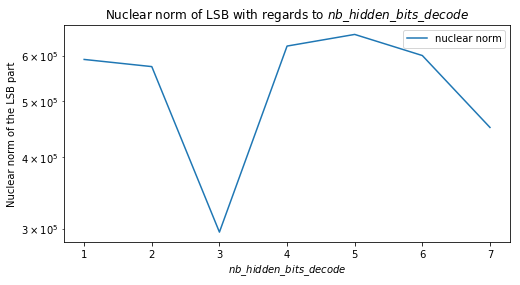

In [22]:
plt.figure(figsize = (8, 4))

plt.yscale('log')
plt.plot(range(1,8), vector_norm_nuc, label = 'nuclear norm')
plt.title(r'Nuclear norm of LSB with regards to $nb\_hidden\_bits\_decode$')
plt.xlabel('$nb\_hidden\_bits\_decode$')
plt.ylabel('Nuclear norm of the LSB part')
plt.legend()

plt.show()

## Finding the optimal parameter by resolving an equation  <a name="equation"></a>


In [23]:
def find_nb_bit(image):
    '''
    Input : image - a picture
    Output : output - the optimal parameter      
    '''
    
    
    '''
    - u=pixel[i,j] 
    - v=pixel[i, j+1]
    - A est le nombre de couples u,v tels que u=v
    - B est le nombre de couples u,v tels que (v est pair et u < v) ou (v est impair et u>v)
    - C est le nombre de couples u,v tels que (v est pair et u > v) ou (v est impair et u<v)
    - D est le nombre de couples u,v de C tels que |u-v|=1
    - E = C-D
    - S est le nombre total de couples et S = B+D+E+A = B+C+A
    Si un message est caché, sa longueur relative (proportion de bits modifiés) est 
    donnée par la plus petite racine de l’équation du second degré : 
    (D+A)/2  x^2 + (2*B-S) x – B =0.
    '''
    pixel=image.copy()
    r=[]
    s=[]
    t=[]
    s_bis=[]
    t_bis=[]
    for p in range(8):
        A =0
        B = 0
        C = 0
        D = 0
        for i in range(image.shape[0]):
            for j in range(image.shape[1]-1):
                u= int(format(pixel[i,j] ,'08b')[:8-p])
                v= int(format(pixel[i, j+1],'08b')[:8-p])
                A += (u==v)
                B += ((v%2==0) and (u<v)) +  ((v%2==1) and (u>v))
                C += ((v%2==0) and (u>v)) +  ((v%2==1) and (u<v))
                D += ((((v%2==0) and (u>v)) +  ((v%2==1) and (u<v)) ) and (abs(u-v)==1))
                E = C-D
                S = B+C+A
        coeff = [(D+A)/2 , (2*B-S) , -B]
        sol= np.roots(coeff)
        r.append(sol)
        s_bis.append(min([i for i in sol]))
        t_bis.append(s_bis[p]- ((1/(p+1))*(sum(s_bis[:p]))))

    u_bis = [(s_bis[i]- s_bis[i+1]) for i in range(7)]
    return(np.argmax(u_bis)+1)

In [24]:
%%time

if False:
    original_carrier = misc.ascent()
    original_hidden = misc.face()

    # Optimal size    
    x_min = min(original_carrier.shape[0], original_hidden.shape[0])
    y_min = min(original_carrier.shape[1], original_hidden.shape[1])

    #Correction of the hidden image (ALAMANO)
    hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
    hidden = hidden[:,:,0]
    carrier = original_carrier

    #Correction of the hidden image (ALAMANO)
    hidden = original_hidden[100:(x_min+100), 350:(y_min+350)]
    hidden = hidden[:,:,0]
    carrier = original_carrier

#Encode for different value of nb_hidden_bits_encode
for nb_hidden_bits_encode in range(1,8):
    output = carrier.copy()
    for i in range(carrier.shape[0]):
        for j in range(carrier.shape[1]):
            output[i,j] = code_steganography_lsb(carrier[i,j], hidden[i,j], nb_hidden_bits_encode)
    print('nb_hidden_bits_encode = ',nb_hidden_bits_encode)
    begin_time = time.time()
    print('find_nb_bit(output) :',find_nb_bit(output))
    taken_time = time.time() - begin_time
    print('It takes %.2fs' %taken_time)

nb_hidden_bits_encode =  1
find_nb_bit(output) : 1
It takes 12.19s
nb_hidden_bits_encode =  2
find_nb_bit(output) : 2
It takes 10.84s
nb_hidden_bits_encode =  3
find_nb_bit(output) : 3
It takes 11.48s
nb_hidden_bits_encode =  4
find_nb_bit(output) : 4
It takes 11.34s
nb_hidden_bits_encode =  5
find_nb_bit(output) : 5
It takes 11.52s
nb_hidden_bits_encode =  6
find_nb_bit(output) : 6
It takes 12.42s
nb_hidden_bits_encode =  7
find_nb_bit(output) : 7
It takes 11.75s
Wall time: 1min 31s


This method works for any value of nb_hidden_bits_encode, but it requires twice as mush computation time than the nuclear method.